# Arbaro demo scene

Notebook: Hannah Weiser, 2025

This demo showcases two highly detailed tree models scanned from two terrestrial laser scanning (TLS) scanning positions.

## Imports

In [1]:
import helios
from helios.settings import OutputFormat, LogVerbosity # these should not have to be imported extra?
import numpy as np

## Creating the virtual scene

Our virtual scene consists of three scene parts - a ground plane and two trees - all loaded as 3D models in .OBJ format. The ground plane is additionally scaled by a factor of 100.

The tree models use the y-axis as "up" axis, which is typical for 3D models in Blender. Hence, we set `up_axis="y"` (default is "z"). We furthermore scale the tree models down to half their size and translate them to position them in the scene. Finally, we create a static scene from the loaded scene parts.

In [2]:
# load objs and create transformations
groundplane = helios.ScenePart.from_obj("../data/sceneparts/basic/groundplane/groundplane.obj").scale(100)  # scale groundplane by 100
tree1 = helios.ScenePart.from_obj("../data/sceneparts/arbaro/black_tupelo_low.obj", up_axis="y")  # 3D models exported from Blender often have the Y-axis as "up-axis"
tree2 = helios.ScenePart.from_obj("../data/sceneparts/arbaro/sassafras_low.obj", up_axis="y")
# Trees should both be scaled down by half and translated
tree1 = tree1.scale(0.5).translate([0.0, 15.0, 0.0])
tree2 = tree2.scale(0.5).translate([-10.0, 15.0, 0.0])
#create scene
scene = helios.StaticScene(scene_parts=[groundplane, tree1, tree2])

## Platform and scanner

HELIOS++ comes with a wide range of pre-defined scanners and platforms, which we can import and instantiate from the `scanner` and `platforms` submodules by their ID.

In [3]:
from helios.scanner import riegl_vz_400
from helios.platforms import tripod

scanner = riegl_vz_400()
platform = tripod()

**ToDo**:
Using the to-be-implemented method to display scanner parameters (nicely formatted), explain the effective maximum scan angle, cf. this notebook: https://github.com/3dgeo-heidelberg/helios/blob/main/example_notebooks/7-tls_sphere_xyzloader.ipynb

## Scanner settings

Below, we define two sets of scanner settings, which will be used for the two legs. In the first version (`scanner_settings1`), we define the scan frequency and the head rotation speed for the scanner. 

However, for TLS, users typically do not specify these settings, but instead provide a vertical and horizontal angular resolution. This is demonstrated in the `scanner_settings2`. HELIOS++ then internally computed the needed scan frequency and head rotation speed to achieve these resolutions.

Note that we can set units in two different ways, either expressed as strings like `"10 deg/s"` or by multiplying with units from the `helios.units` object. This is implemented with the Python package [`pint`](https://github.com/hgrecco/pint).
Note that these are the default units that HELIOS++ uses:
- Angle: rad 
- Frequency: Hz
- Length: m
- TimeInterval: s

So especially for angles, users are advised to take care of the radians to degree conversion where needed.

In [4]:
# these scanner settings will be shared between all legs
scanner_settings1 = helios.ScannerSettings(pulse_frequency=100_000,  # Hz
                                           scan_frequency=120,  # Hz
                                           min_vertical_angle=-40 * helios.units.deg,  # °
                                           max_vertical_angle=60 * helios.units.deg,
                                           head_rotation="10 deg/s"
                                          )
# for rotating head and rotating mirror terrestrial laser scanners, we can also provide 
# the vertical and horizontal angular resolution instead of scan frequency and head rotation speed
scanner_settings2 = helios.ScannerSettings(pulse_frequency=100_000,  # Hz
                                           vertical_resolution=0.2,# * helios.units.deg,
                                           horizontal_resolution=0.2,# * helios.units.deg,
                                           min_vertical_angle=-40 * helios.units.deg,
                                           max_vertical_angle=60 * helios.units.deg
                                          )

fullwave_settings = helios.FullWaveformSettings(
    bin_size=0.2 * helios.units.ns,
    beam_sample_quality=3  # default
)

## Scan positions

Next, we define two scan positions for our TLS survey. In HELIOS++, scan positions (or waypoints for mobile surveys) are called "legs". Below, we first create the survey with our defined scanner, platform and scene and then add the two legs, specifying the platform positions and the horizontal field of view of the sensor.

In [5]:
survey = helios.Survey(scanner=scanner, platform=platform, scene=scene)
# first scan position
survey.add_leg(scanner_settings=scanner_settings1,
               x=1.0,
               y=25.5,
               z=1.5,
               force_on_ground=True,  # this works because of the specification in the groundplane.mtl file
               rotation_start_angle=100 * helios.units.deg,
               rotation_stop_angle=225 * helios.units.deg
              )
# second scan position, here we use the other scan setting definition
survey.add_leg(scanner_settings=scanner_settings1,  # scanner_settings2 is not working..
               x=-4.0,
               y=-2.5,
               z=1.5,
               force_on_ground=True,
               rotation_start_angle=-45 * helios.units.deg,
               rotation_stop_angle=45 * helios.units.deg
              )

## Executing the survey

Per defult, the `survey.run()` method returns two NumPy arrays, points measurements and the recorded trajectory.

In [6]:
points, trajectories = survey.run(verbosity=LogVerbosity.VERBOSE, format=OutputFormat.NPY)

In the default NPY case, `points` and `trajectories` are NumPy arrays of structured data type:

In [7]:
points[:3]

array([(0, 0, [-7.76286745e+00,  2.39428034e+01, -4.12427038e-05], [-0.92650733, -0.16464405, -0.33834378], [ 1.       , 25.5      , -3.7726975], 9.45795808, 3167609.35520265, 0., 1, 1, 70, 0, 582299.00764),
       (0, 0, [-7.89797736e+00,  2.39187779e+01,  1.82534276e-03], [-0.92816979, -0.16494115, -0.33360943], [ 1.       , 25.5      , -3.7726975], 9.58658363, 3325874.54706395, 0., 1, 1, 71, 0, 582299.00765),
       (0, 0, [-8.04519183e+00,  2.38926007e+01,  7.81115161e-04], [-0.92980881, -0.16523409, -0.32886665], [ 1.       , 25.5      , -3.7726975], 9.72801261, 3463080.31858568, 0., 1, 1, 72, 0, 582299.00766)],
      dtype=[('channel_id', '<u8'), ('hit_object_id', '<i4'), ('position', '<f8', (3,)), ('beam_direction', '<f8', (3,)), ('beam_origin', '<f8', (3,)), ('distance', '<f8'), ('intensity', '<f8'), ('echo_width', '<f8'), ('return_number', '<i4'), ('number_of_returns', '<i4'), ('fullwave_index', '<i4'), ('classification', '<i4'), ('gps_time', '<f8')])

In [8]:
trajectories[:3]

array([(582299.  , [ 1. , 25.5,  1.5], -0., 0., -0.),
       (582299.01, [ 1. , 25.5,  1.5], -0., 0., -0.),
       (582299.02, [ 1. , 25.5,  1.5], -0., 0., -0.)],
      dtype=[('gps_time', '<f8'), ('position', '<f8', (3,)), ('roll', '<f8'), ('pitch', '<f8'), ('yaw', '<f8')])

If we want a different output format, we need to change the `format` parameter of the method. Available options are:
- NPY (default)
- LAS
- LAZ
- XYZ
- LASPY

Not that the LASPY format also returns two Python objects, but the first is a `laspy.LasData` instance instead of a NumPy array. 

If LAS, LAZ, or XYZ are provided as format, then the output is written to file and the `.run()` method of the survey returns only a single value, the path to the created output directory.

We can also set different log verbosity levels.

In [9]:
survey.run(verbosity=LogVerbosity.QUIET, format=OutputFormat.LAZ)

WindowsPath('D:/Software/_helios_versions/helios_dev/example_notebooks/output/2025-11-01_18-45-14')

## Visualizing the result

Finally, let's visualize the simulated points using `matplotlib`.

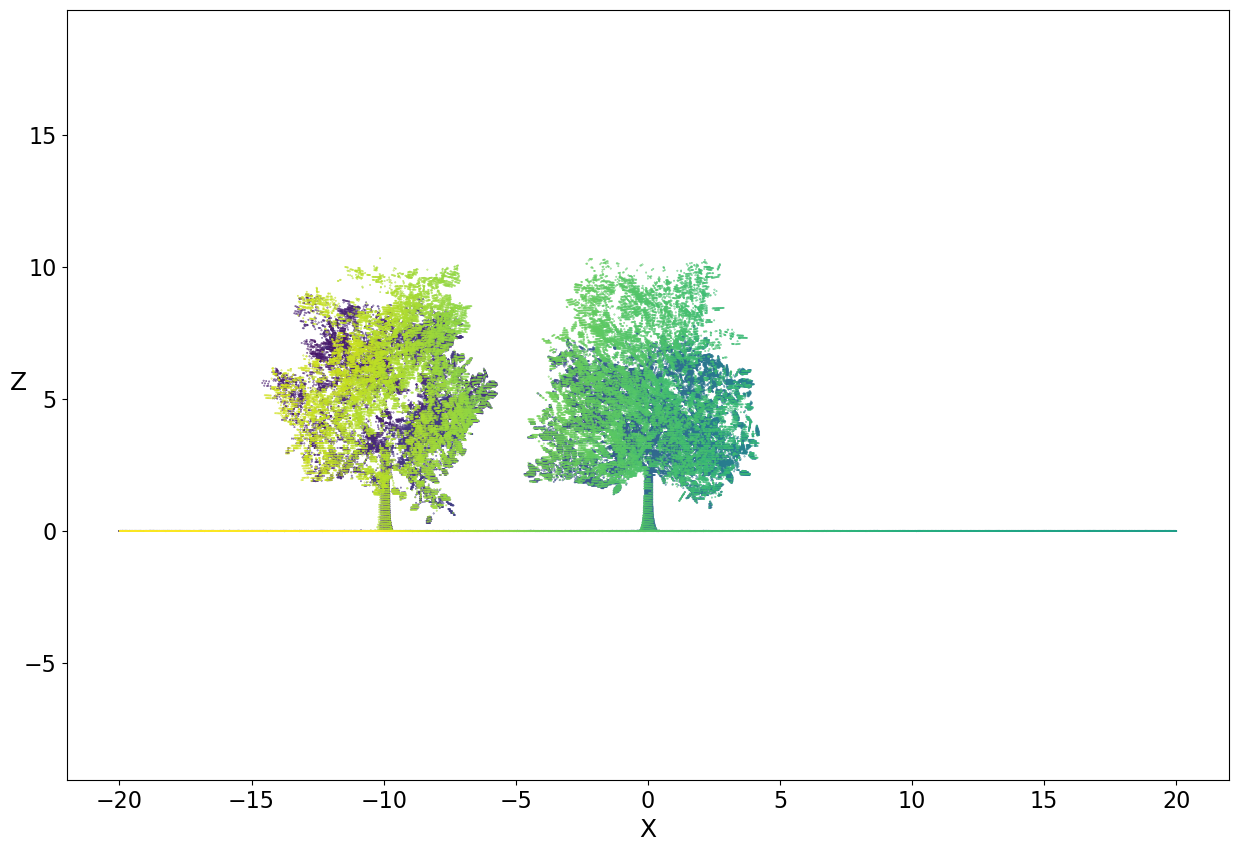

In [11]:
import matplotlib.pyplot as plt

pos = points["position"]

# discard points outside of [-20, -20] to [20, 20] (x, y)
points_sub = points[
    (pos[:, 0] > -20) & (pos[:, 1] > -20) & (pos[:, 0] < 20) & (pos[:, 1] < 20)
]
pos = points_sub["position"]

fig, ax = plt.subplots(figsize=(15, 10))
ax.scatter(
   pos[:, 0], pos[:, 2], s=0.1, c=points_sub["gps_time"]
)
plt.axis("equal")
ax.tick_params(labelsize=16)
plt.xlabel("X", fontsize=18)
plt.ylabel("Z", fontsize=18, rotation=0)
plt.show()